# Quick Tour

<a target="_blank" href="https://colab.research.google.com/github/lavague-ai/LaVague/blob/main/docs/docs/get-started/quick-tour-notebook/quick-tour.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

## Pre-requisites

**Note**: We use OpenAI's models, for the embedding, LLM and Vision model. You will need to set the OPENAI_API_KEY variable in your local environment with a valid API key for this example to work.

If you don't have an OpenAI API key, please get one here: https://platform.openai.com/docs/quickstart/developer-quickstart

# Installation

We start by download LaVague.

In [1]:
!pip install lavague

Next, we will initialize the default Selenium webdriver, which will be used to execute our actions on the web.

In [2]:
from lavague.drivers.selenium import SeleniumDriver

selenium_driver = SeleniumDriver()

We will need to set our OpenAI Key as a Colab secret (see the key icon on the left-hand side of the Colab notebook) named 'OPENAI_API_KEY' and then convert it to an environment variable with the same name.

In [5]:
import os

# Check if running in Google Colab
try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
else:
    os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

We will then build an `ActionEngine`, which is responsible for generating automation code for text instructions and executing them.

By default, our`AcionEngine` will use the following configuration:
- LLM: `OpenAI's gpt-4-1106-preview`
- Embedder: `OpenAI's text-embedding-3-large`
- Retriever: `OPSM retriever`

In [ ]:
from lavague.core import ActionEngine

action_engine = ActionEngine(selenium_driver)

# World model

Here we will introduce World Models, which are models whose goal is to take a given set of:
- Objective: here the goal to be achieved
- State: here a screenshot of the current page

and outputs an instruction that our `ActionEngine` can turn into Selenium code.

Our current world model uses GPT4 with Vision to output an instruction using a screenshot and a given objective.

We can have a look at the current prompt template we will use:

In [ ]:
from lavague.core.world_model import WORLD_MODEL_PROMPT_TEMPLATE

print(WORLD_MODEL_PROMPT_TEMPLATE.template)


You are an AI system specialized in high level reasoning. Your goal is to generate instructions for other specialized AIs to perform web actions to reach objectives given by humans.
Your inputs are an objective in natural language, as well as a screenshot of the current page of the browser.
Your output are a list of thoughts in bullet points detailling your reasoning, followed by your conclusion on what the next step should be in the form of an instruction.
You can assume the instruction is used by another AI to generate the action code to select the element to be interacted with and perform the action demanded by the human.

The instruction should be detailled as possible and only contain the next step. 
Do not make assumptions about elements you do not see.
If the objective is already achieved in the screenshot, provide the instruction 'STOP'.

Here are previous examples:
${examples}

Objective: ${objective}
Thought:



Next, we will initialize our WorldModel. To do this, we need to provide the WorldModel with knowledge on how to interact with our chosen website. This knowledge consists of  previous examples for this website of turning observations into instructions, that are then turned into actions.

We can initialize our WorldModel with one of three methods, allowing us to provide this knowledge in different formats:
- `WorldModel.from_hub("URL_SLUG")` : with the `from_hub()` method, we can pull the knowledge from a `.txt` file in the `examples/knowledge` folder of our GitHub repo, which acts as a hub for sharing knowledge files. For our `examples/knowledge/hf_example.txt` file, we provide `hf_example` as input to our `from_hub()` method.
- `WorldModel.from_local("PATH_TO_LOCAL_FILE")`: With the `from_local()` method, you can provide knowledge from a local file.
- `WorldModel("KNOWLEDGE_AS_STRING")`: You can also directly initialize a `WorldModel` with your knowledge as a string.

For the purposes of this demo, we will use the `from_hub()` method.

In [ ]:
from lavague.core import WorldModel

world_model = WorldModel.from_hub("hf_example")

# Demo

We can now play with it, with a small example where we show our World Model can help achieve a specific goal, here going on the quicktour of Hugging Face's PEFT framework for model finetuning, by providing instructions to our `ActionEngine`:

In [ ]:
from lavague.core import WebAgent

agent = WebAgent(action_engine, world_model)

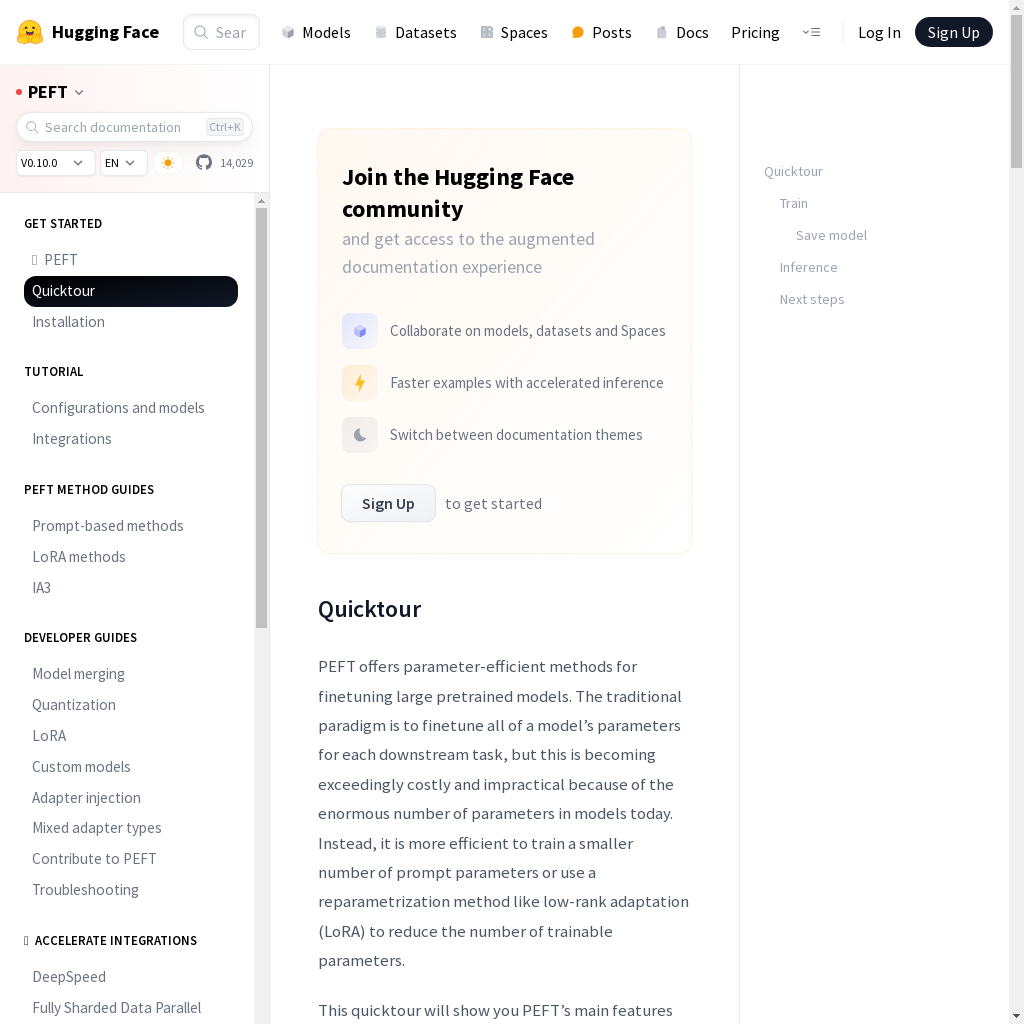

Computing an action plan...
Thoughts: Thoughts:
- The current screenshot shows the documentation page for PEFT on the Hugging Face website.
- The left sidebar clearly lists "Quicktour" under the "GET STARTED" section, which is already highlighted.
- The main content area on the right side of the page is displaying the "Quicktour" section of PEFT.
- The content includes headings like "Train", "Save model", "Inference", and "Next steps", which are part of the quicktour.
- Since the objective is to go on the quicktour of PEFT and the page is already displaying this information, no further navigation or action is required.

Instruction: STOP
Objective reached


In [ ]:
agent.get("https://huggingface.co/docs")
agent.run("Go on the quicktour of PEFT")